# Chapter 8
## Dimensionality Reduction

In [2]:
import numpy as np

In [8]:
from sklearn.datasets import make_swiss_roll

In [14]:
X_swiss, t = make_swiss_roll(n_samples=1000, noise=0.2, random_state=42)

In [16]:
import matplotlib.pyplot as plt

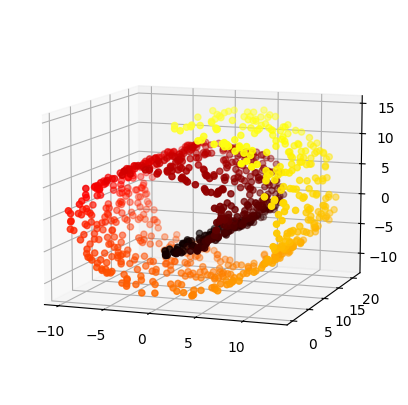

In [28]:
from matplotlib.colors import ListedColormap

darker_hot = ListedColormap(plt.cm.hot(np.linspace(0, 0.8, 256)))

axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_swiss[:, 0], X_swiss[:, 1], X_swiss[:, 2], c=t, cmap=darker_hot)
ax.view_init(10, -70)
plt.show()

In [32]:
X_centered = X_swiss - X_swiss.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt[0]
c2 = Vt[1]

In [39]:
W2 = Vt[:2].T
X2D = X_centered @ W2

In [41]:
X2D

array([[  2.08374001,   9.97769318],
       [ 12.53136592,   4.15352368],
       [ -4.26069341, -11.17296129],
       ...,
       [ -0.57812196,  -2.30906044],
       [ 10.64441015,   6.37488622],
       [ -3.04227432,  11.58268844]])

In [54]:
darker_hot = ListedColormap(plt.cm.hot(np.linspace(0, 0.8, 256)))

axes = [-11.5, 14, -2, 23, -12, 15]

fig = plt.figure(figsize=(6, 5))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X2D[:, 0], X2D[:, 1], c=t, cmap=darker_hot)
ax.view_init(10, -70)
plt.show()

This was projecting the swiss roll dataset directly on a 2D plane.
we could do the same with a random 3D dataset.

In [63]:
from scipy.spatial.transform import Rotation

In [70]:
m = 60
X = np.zeros((m, 3))
np.random.seed(42)
angles = (np.random.rand(m) ** 3 + 0.5) * 2 * np.pi
X[:, 0], X[:, 1] = np.cos(angles), np.sin(angles) * 0.5
X += 0.28 * np.random.randn(m, 3)
X = Rotation.from_rotvec([np.pi / 29, -np.pi / 20, np.pi / 4]).apply(X)
X += [0.2, 0, 0.2]

In [72]:
X_centered = X-X.mean(axis=0)
U, s, Vt = np.linalg.svd(X_centered)
c1 = Vt[0]
c2 = Vt[1]

In [74]:
W2 = Vt[:2].T
X2D = X_centered @ W2

In [76]:
from sklearn.decomposition import PCA

In [78]:
pca = PCA(n_components=2)
X2D = pca.fit_transform(X)

In [80]:
pca.explained_variance_ratio_

array([0.7578477 , 0.15186921])

In [82]:
from sklearn.datasets import fetch_openml

In [84]:
mnist = fetch_openml('mnist_784', as_frame = False)
X_train, y_train = mnist.data[:60_000], mnist.target[:60_000]
X_test, y_test = mnist.data[60_000:], mnist.target[60_000:]

In [86]:
pca = PCA()
pca.fit(X_train)
cumsum = np.cumsum(pca.explained_variance_ratio_)
d = np.argmax(cumsum >= 0.95) + 1

In [88]:
d

154

In [90]:
pca = PCA(n_components=0.95)
X_reduced = pca.fit_transform(X_train)

In [92]:
pca.n_components_

154

In [94]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.pipeline import make_pipeline

In [96]:
clf = make_pipeline(PCA(random_state=42),
                   RandomForestClassifier(random_state=42))

param_distrub = {
    "pca__n_components" : np.arange(10,80),
    "randomforestclassifier__n_estimators" : np.arange(50, 5000)
}

rnd_search = RandomizedSearchCV(clf, param_distrub, n_iter=10, cv=3,
                               random_state=42)
rnd_search.fit(X_train[:1000], y_train[:1000])

RandomizedSearchCV(cv=3,
                   estimator=Pipeline(steps=[('pca', PCA(random_state=42)),
                                             ('randomforestclassifier',
                                              RandomForestClassifier(random_state=42))]),
                   param_distributions={'pca__n_components': array([10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
       27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43,
       44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59, 60,
       61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 77,
       78, 79]),
                                        'randomforestclassifier__n_estimators': array([  50,   51,   52, ..., 4997, 4998, 4999])},
                   random_state=42)

In [97]:
print(rnd_search.best_params_)

{'randomforestclassifier__n_estimators': 3208, 'pca__n_components': 34}


In [98]:
rnd_pca = PCA(n_components=154, svd_solver="randomized", random_state=42)
X_reduced = rnd_pca.fit_transform(X_train)

In [102]:
#Incremental PCA if the dataset cant fit in RAM

In [104]:
from sklearn.decomposition import IncrementalPCA

In [106]:
n_batches = 100
inc_pca = IncrementalPCA(n_components=154)
for X_batch in np.array_split(X_train, n_batches):
    inc_pca.partial_fit(X_batch)

X_reduced = inc_pca.transform(X_train)

In [108]:
#use memmap to directly use fit() instead of partial_fit()

In [110]:
from sklearn.random_projection import johnson_lindenstrauss_min_dim

In [112]:
m, e = 5000, 0.1
d = johnson_lindenstrauss_min_dim(m, eps = e)
d

7300

In [116]:
n = 20_000
np.random.seed(42)
P = np.random.randn(d, n) / np.sqrt(d)

X = np.random.randn(m, n)
X_reduced = X @ P.T

In [118]:
from sklearn.random_projection import GaussianRandomProjection

In [120]:
gaussian_rnd_proj = GaussianRandomProjection(eps = e, random_state=42)
X_reduced = gaussian_rnd_proj.fit_transform(X)

In [122]:
components_pinv = np.linalg.pinv(gaussian_rnd_proj.components_)
X_recovered = X_reduced @ components_pinv.T

### LLE
#### Locally Linear Embedding

In [127]:
from sklearn.datasets import make_swiss_roll
from sklearn.manifold import LocallyLinearEmbedding

In [131]:
X_swiss, t = make_swiss_roll(n_samples = 1000, noise=0.2, random_state=42)
lle = LocallyLinearEmbedding(n_components=2, n_neighbors=10, random_state=42)
X_unrolled = lle.fit_transform(X_swiss)